In [12]:
from cs_entropy import *
from color_compass import *
from code_definitions import *

from tqdm import tqdm

# autoreload 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 5-qubit code

In [15]:
code = FiveQubitCode()

In [16]:
print(code.tableau)

+-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++
| XZ XX __ XX _Z
| XZ _Z XX __ XX
| XZ XZ XZ _X X_
| XZ XX _Z _Z XX
| XZ X_ _X XZ XZ


In [17]:
noise = BiasedPauliNoise(0.3, 0.3, 5)
joint_dist = code.make_joint_distribution(noise)

In [18]:
error = PauliString('ZZZZZ')
print(code.logical_effect(error))

[1. 0.]


In [25]:
syndrome_marginal = calculate_syndrome_marginal_distribution(joint_dist)
syndrome_marginal

{(0.0, 0.0, 0.0, 0.0): 0.06444205,
 (0.0, 0.0, 1.0, 1.0): 0.06240441000000001,
 (0.0, 1.0, 1.0, 1.0): 0.06230277000000001,
 (0.0, 1.0, 0.0, 0.0): 0.06240441,
 (0.0, 1.0, 1.0, 0.0): 0.06240441000000001,
 (0.0, 1.0, 0.0, 1.0): 0.062404409999999993,
 (0.0, 0.0, 0.0, 1.0): 0.06240441,
 (0.0, 0.0, 1.0, 0.0): 0.06240441,
 (1.0, 1.0, 1.0, 1.0): 0.06230277000000001,
 (1.0, 1.0, 0.0, 0.0): 0.06240441000000001,
 (1.0, 0.0, 0.0, 0.0): 0.062404409999999993,
 (1.0, 0.0, 1.0, 1.0): 0.06230277,
 (1.0, 0.0, 0.0, 1.0): 0.06240441000000001,
 (1.0, 0.0, 1.0, 0.0): 0.06240441000000001,
 (1.0, 1.0, 1.0, 0.0): 0.06230277000000001,
 (1.0, 1.0, 0.0, 1.0): 0.06230277000000001}

In [26]:
logical_marginal = calculate_logical_marginal_distribution(joint_dist)
logical_marginal

{(0.0, 0.0): 0.2501776816,
 (0.0, 1.0): 0.25007999999999997,
 (1.0, 1.0): 0.24966231839999997,
 (1.0, 0.0): 0.25007999999999997}

In [27]:
calculate_syndrome_marginal_distribution

<function code_definitions.calculate_syndrome_marginal_distribution(joint_distribution)>

In [28]:
print(calculate_conditional_entropy(joint_dist))
print(calculate_mutual_information(joint_dist))
print(calculate_logical_entropy(joint_dist))


1.997873768317378
0.0021257745152214458
1.9999995428325994


In [29]:
def make_joint_dist_grid(code, px_line, pz_line):
    joint_dists = dict()
    for px in tqdm(px_line):
        for pz in pz_line:
            noise = BiasedPauliNoise(px, pz, code.num_qubits)
            joint_dists[(px, pz)] = code.make_joint_distribution(noise)
    return joint_dists
    

In [48]:
px_line = np.linspace(0, 0.2, 21)
pz_line = np.linspace(0, 0.2, 21)
joint_dists = make_joint_dist_grid(code, px_line, pz_line)

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:20<00:00,  1.00it/s]


In [49]:
# plot the conditional entropies on a grid
cond_entropies = np.zeros((len(px_grid), len(pz_grid)))
for i, px in enumerate(px_grid):
    for j, pz in enumerate(pz_grid):
        joint_dist = joint_dists[(px, pz)]
        cond_entropies[i, j] = calculate_conditional_entropy(joint_dist)

plt.imshow(cond_entropies, origin='lower', extent=(0, 0.2, 0, 0.2))
plt.colorbar()

NameError: name 'px_grid' is not defined

In [50]:
def plot_fun_on_grid(fun, grid_dict, px_line, pz_line, title=None):
    grid = np.zeros((len(px_line), len(pz_line)))
    for i, px in enumerate(px_line):
        for j, pz in enumerate(pz_line):
            grid[i, j] = fun(grid_dict[(px, pz)])
    plt.imshow(grid, origin='lower', extent=(0, 0.2, 0, 0.2))
    plt.colorbar()
    if title:
        plt.title(title)


def plot_fun_on_colormesh(fun, grid_dict, px_line, pz_line, title=None):
    grid = np.zeros((len(px_line), len(pz_line)))
    for i, px in enumerate(px_line):
        for j, pz in enumerate(pz_line):
            grid[i, j] = fun(grid_dict[(px, pz)])
    plt.pcolormesh(px_line, pz_line, grid, shading='auto', cmap='PiYG')
    plt.colorbar()
    if title:
        plt.title(title)
    

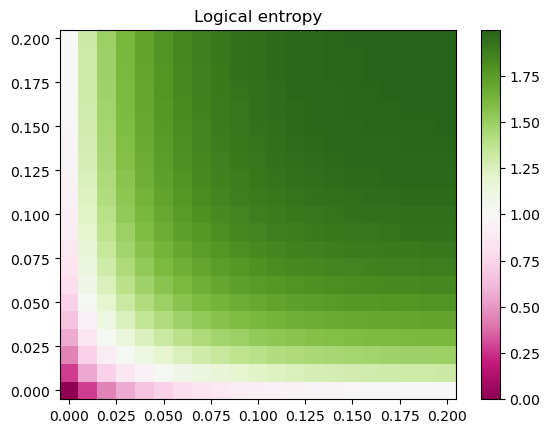

In [51]:
plot_fun_on_colormesh(calculate_logical_entropy, joint_dists, px_line, pz_line, title='Logical entropy')

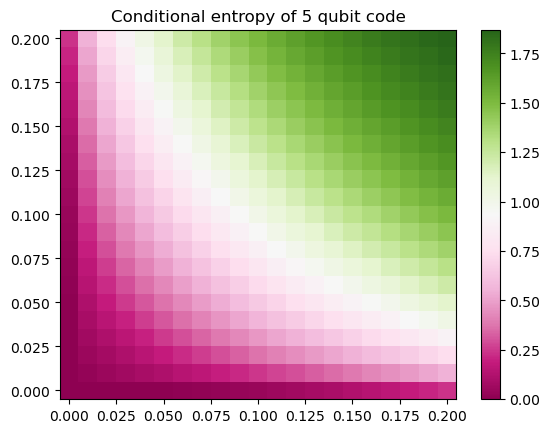

In [52]:
plot_fun_on_colormesh(calculate_conditional_entropy, joint_dists, px_line, pz_line, title='Conditional entropy of 5 qubit code')
# save in pdf
plt.savefig('conditional_entropy_5qubit.pdf')

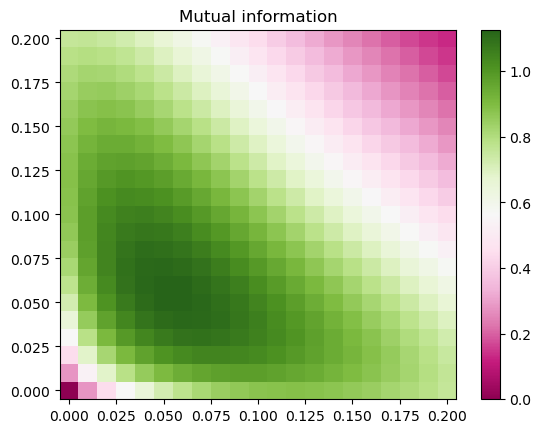

In [37]:
plot_fun_on_colormesh(calculate_mutual_information, joint_dists, px_line, pz_line, title='Mutual information')

In [38]:
# plot the mutual information for a depolarizing channel with increasing bias 

class DepolarizingChannel(SeparablePauliNoise):
    def __init__(self, p, num_qubits):
        pZ = p/3 
        pX = p/3
        pY = p/3
        super().__init__(pX, pY, pZ, num_qubits)

In [39]:
p_line = np.linspace(0, 0.5, 100)
joint_dists = [code.make_joint_distribution(DepolarizingChannel(p, 5)) for p in tqdm(p_line)]

100%|██████████| 100/100 [00:04<00:00, 20.74it/s]


In [40]:
mutual_infos = [calculate_mutual_information(joint_dist) for joint_dist in joint_dists]
conditional_entropies = [calculate_conditional_entropy(joint_dist) for joint_dist in joint_dists]
logical_entropies = [calculate_logical_entropy(joint_dist) for joint_dist in joint_dists]


In [41]:
# calculate the entropy of the single-qubit depolarizing channel on the grid
sq_entropies = [entropy(DepolarizingChannel(p, 1).pvec_1q) for p in p_line]
five_qubit_entropies = [5*s for s in sq_entropies]

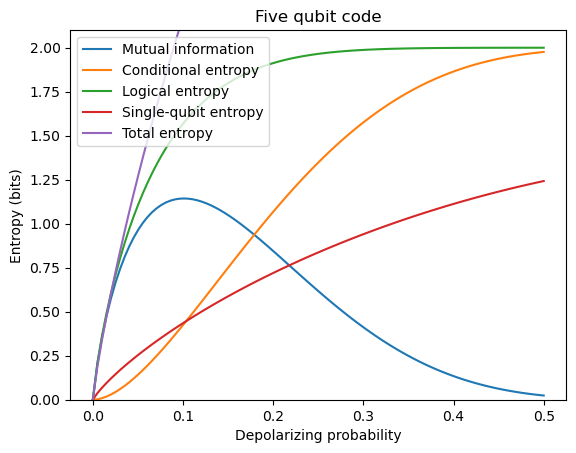

In [47]:
plt.plot(p_line, mutual_infos, label='Mutual information')
plt.plot(p_line, conditional_entropies, label='Conditional entropy')
plt.plot(p_line, logical_entropies, label='Logical entropy')
plt.plot(p_line, sq_entropies, label='Single-qubit entropy')
plt.plot(p_line, five_qubit_entropies, label='Total entropy')
plt.legend()
plt.xlabel('Depolarizing probability')
plt.ylabel('Entropy (bits)')
plt.title('Five qubit code')
plt.ylim(0, 2.1)
# save in PDF
plt.savefig('five_qubit_entropies.pdf')

# Key ideas:

- The Pauli distribution that maximizes mutual information represents the maximal entropy extraction rate of the code (but it will have residual entropy)
- The conditional entropy relates to the expected success probability per
$$
    r = 2^{-m H(Z|Y)}
$$
where $m$ is the number of uses of the code
- The crossing between the conditional entropy and the (average) single-qubit entropy may be understood as the point at which the code stops perfoming better than its constitutes (specifically, it is the point at which the residual entropy in the code space is larger than the entropy of a single qubit)

# Questions:

- 


# Steps: 

- Do the same calc for the steane code and some compass codes (under depolarizing noise)
- make the biased noise grids for the steane code and some compass codes
- 

In [534]:
# find the point where the conditional entropy crosses the single-qubit entropy
# this is the threshold for the depolarizing channel

# do this by first fitting a spline to the data
from scipy.interpolate import interp1d
spline = interp1d(p_line, conditional_entropies, kind='cubic')
spline_sq = interp1d(p_line, sq_entropies, kind='cubic')

# then find the root of the difference, but exclude the starting point
from scipy.optimize import root_scalar
root = root_scalar(lambda p: spline(p) - spline_sq(p), bracket=[0.1, 0.5])
threshold = root.root
threshold

0.1034574042213498

In [535]:
threshold

0.1034574042213498

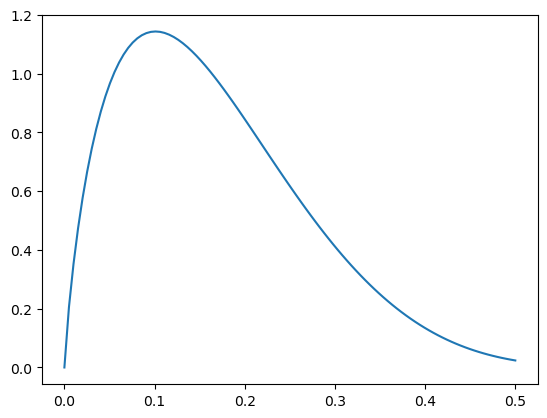

In [536]:
plt.plot(p_line, mutual_infos, label='Mutual information')

# find the distribution that maximizes mutual information 

In [537]:
def mutual_information_for_bias(px, py, pz, code):
    noise = SeparablePauliNoise(px, py, pz, code.num_qubits)
    joint_dist = code.make_joint_distribution(noise)
    return calculate_mutual_information(joint_dist)

# find the px, py, pz that maximizes the mutual information
from scipy.optimize import minimize

cost = lambda x: -mutual_information_for_bias(x[0], x[1], x[2], code)
initial_guess = [0.1, 0.1, 0.1]
res = minimize(cost, initial_guess, bounds=[(0, 0.2)]*3)
res.x, -res.fun

(array([0.03366859, 0.03366859, 0.03366859]), 1.1434965939111885)

In [538]:
px_opt, py_opt, pz_opt = res.x
noise = SeparablePauliNoise(px_opt, py_opt, pz_opt, code.num_qubits)
joint_dist = code.make_joint_distribution(noise)
print(calculate_logical_entropy(joint_dist))
print(calculate_conditional_entropy(joint_dist))
print(calculate_mutual_information(joint_dist))

1.5742338554498385
0.43073726153865
1.1434965939111885


# steane code

In [552]:
# five_qubit_code_stabilizers = [
#     PauliString('XZZXI'), 
#     PauliString('IXZZX'),
#     PauliString('XIXZZ'),
#     PauliString('ZXIXZ'),
# ]
# five_qubit_code_Lx = PauliString('XXXXX')
# five_qubit_code_Lz = PauliString('ZZZZZ')

# code = StabilizerCode([[five_qubit_code_Lx], [five_qubit_code_Lz]], five_qubit_code_stabilizers)

steane_code_stabilizers = [
    PauliString('IIIXXXX'), 
    PauliString('IXXIIXX'), 
    PauliString('XIXIXIX'),
    PauliString('IIIZZZZ'),
    PauliString('IZZIIZZ'),
    PauliString('ZIZIZIZ'),
]

steane_code_Lx = PauliString('XXXXXXX')
steane_code_Lz = PauliString('ZZZZZZZ')

code = StabilizerCode([[steane_code_Lx], [steane_code_Lz]], steane_code_stabilizers)
print(code.tableau)

+-xz-xz-xz-xz-xz-xz-xz-
| ++ ++ ++ ++ ++ ++ ++
| XZ __ __ _X X_ __ _Z
| _Z __ ZX Z_ __ _Z __
| _Z __ _X ZX __ _Z _Z
| _Z ZX __ __ _Z __ __
| _Z _X __ _X XZ X_ _Z
| XZ _X _X __ _Z _Z X_
| XZ _X _X _X _Z XZ XZ


In [553]:
noise = DepolarizingChannel(0.1, 7)
joint_dist = code.make_joint_distribution(noise)
print(calculate_logical_entropy(joint_dist))
print(calculate_conditional_entropy(joint_dist))
print(calculate_mutual_information(joint_dist))

1.7502927929582033
0.4192979831800234
1.3309948097781799


In [554]:
# make a grid
p_line = np.linspace(0, 0.5, 100)

# calculate the joint distributions on the grid
joint_dists = [code.make_joint_distribution(DepolarizingChannel(p, 5)) for p in tqdm(p_line)]

# calculate the mutual information, conditional entropy, and logical entropy on the grid
mutual_infos = [calculate_mutual_information(joint_dist) for joint_dist in joint_dists]
conditional_entropies = [calculate_conditional_entropy(joint_dist) for joint_dist in joint_dists]
logical_entropies = [calculate_logical_entropy(joint_dist) for joint_dist in joint_dists]

# calculate the entropy of the single-qubit depolarizing channel on the grid
sq_entropies = [entropy(DepolarizingChannel(p, 1).pvec_1q) for p in p_line]

100%|██████████| 100/100 [00:05<00:00, 17.72it/s]


(0.0, 2.1)

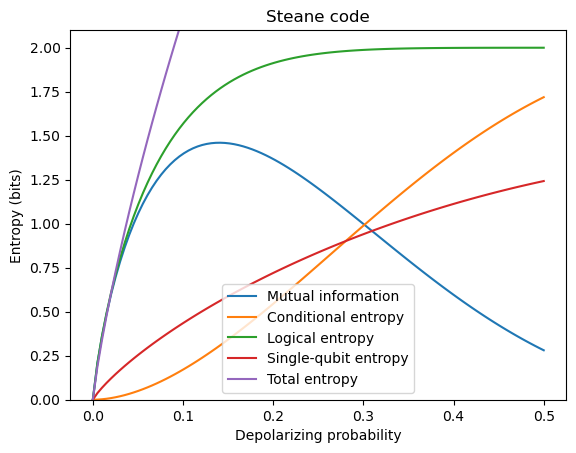

In [558]:
plt.plot(p_line, mutual_infos, label='Mutual information')
plt.plot(p_line, conditional_entropies, label='Conditional entropy')
plt.plot(p_line, logical_entropies, label='Logical entropy')
plt.plot(p_line, sq_entropies, label='Single-qubit entropy')
plt.plot(p_line, five_qubit_entropies, label='Total entropy')
plt.legend()
plt.xlabel('Depolarizing probability')
plt.ylabel('Entropy (bits)')
plt.title('Steane code')
plt.ylim(0, 2.1)

# compass codes

In [556]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red  ~ -1 ~ Z-type cuts
    Blue ~ +1 ~ X-type cuts
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ''.join(['X']*dimX+['_']*dimX*(dimZ-1))
        self.Lz = ''.join((['Z']+['_']*(dimX-1))*dimZ)
        self.logicals = [self.Lx,self.Lz]
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def pcheckZ(self):
        """returns the Z parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSz()])
        
    def pcheckX(self):
        """returns the X parity check matrix"""
        return np.vstack([pauli2vector(s) for s in self.getSx()])
    
    def parity_check_matrix(self):
        """returns the full parity check matrix"""
        return np.vstack([self.pcheckX(), self.pcheckZ()])
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'Z'
                gauge[k + i*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimZ):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]

In [557]:
def make_code_from_lattice(lat):
    """
    make a stabilizer code from a lattice
    """
    Lx = PauliString(lat.Lx)
    Lz = PauliString(lat.Lz)
    S = [PauliString(s) for s in lat.getS()]
    return StabilizerCode([[Lx], [Lz]], S)

In [312]:
noise = BiasedPauliNoise(0.01, 0.0001, 9)
print(noise.entropy(), noise.entropy_1q())

0.8235096052938333 0.09150106725487032


In [313]:
pauli_error = noise.sample_error()
print(pauli_error)

_________


In [314]:
# first make all length-4 lists of elements in {-1, 0, 1}
# then make all 3x3 lattices
# then calculate the entropy of each lattice
# then plot the entropy of each lattice
# then calculate the entropy of each lattice with a depolarizing channel
# then plot the entropy of each lattice with a depolarizing channel

In [315]:
# make all 3x3 lattices
import itertools as _itr

all_colorings = _itr.product([-1, 0, 1], repeat=4)


lattices = []
for i in all_colorings:
    lat = compass_to_surface(3,3)
    lat.color_lattice(i)
    lattices.append(lat)

all_codes = [make_code_from_lattice(lat) for lat in lattices]

In [332]:
surface_lat = compass_to_surface(3,3)
shor_red_lat = compass_to_surface(3,3)
shor_red_lat.color_lattice([-1, -1, -1, -1])
shor_blue_lat = compass_to_surface(3,3)
shor_blue_lat.color_lattice([1, 1, 1, 1])
three_lattices = [surface_lat, shor_red_lat, shor_blue_lat]
surface_code = make_code_from_lattice(surface_lat)
shor_red_code = make_code_from_lattice(shor_red_lat)
shor_blue_code = make_code_from_lattice(shor_blue_lat)
three_codes = [make_code_from_lattice(lat) for lat in three_lattices]

In [340]:
error = PauliString('XIZIZIZIZ')
syndrome = surface_code.syndrome(error)
print(syndrome)
syndrome_recovery = surface_code.syndrome_recovery(syndrome)
print(syndrome_recovery)
print(surface_code.syndrome(syndrome_recovery))
print(surface_code.syndrome(error*syndrome_recovery))

[0. 0. 0. 1. 0. 0. 1. 0.]
+X_Z__ZXXX
[0. 0. 0. 1. 0. 0. 1. 0.]
[0. 0. 0. 0. 0. 0. 0. 0.]


In [334]:
surface_code.logical_effect(error)

array([1., 0.])

In [341]:
syndrome = surface_code.syndrome(error)
print(syndrome)

[0. 0. 0. 1. 0. 0. 1. 0.]


In [342]:
surface_code.tableau

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+______XXX"),
        stim.PauliString("+__ZZZ____"),
        stim.PauliString("+__Z______"),
        stim.PauliString("+__Z_Z____"),
        stim.PauliString("+__Z__Z___"),
        stim.PauliString("+XX____XXX"),
        stim.PauliString("+________X"),
        stim.PauliString("+X_____XXX"),
        stim.PauliString("+_______XX"),
    ],
    zs=[
        stim.PauliString("+Z__Z__Z__"),
        stim.PauliString("+X__X_____"),
        stim.PauliString("+_XX_XX___"),
        stim.PauliString("+___XX_XX_"),
        stim.PauliString("+_____X__X"),
        stim.PauliString("+_ZZ______"),
        stim.PauliString("+____ZZ_ZZ"),
        stim.PauliString("+ZZ_ZZ____"),
        stim.PauliString("+______ZZ_"),
    ],
)

In [343]:
surface_code.destabilizers

[stim.PauliString("+__ZZZ____"),
 stim.PauliString("+__Z______"),
 stim.PauliString("+__Z_Z____"),
 stim.PauliString("+__Z__Z___"),
 stim.PauliString("+XX____XXX"),
 stim.PauliString("+________X"),
 stim.PauliString("+X_____XXX"),
 stim.PauliString("+_______XX")]

In [344]:
surface_code.stabilizer_generators

[stim.PauliString("+X__X_____"),
 stim.PauliString("+_XX_XX___"),
 stim.PauliString("+___XX_XX_"),
 stim.PauliString("+_____X__X"),
 stim.PauliString("+_ZZ______"),
 stim.PauliString("+____ZZ_ZZ"),
 stim.PauliString("+ZZ_ZZ____"),
 stim.PauliString("+______ZZ_")]

In [345]:
surface_code.syndrome_recovery(syndrome)

stim.PauliString("+X_Z__ZXXX")

In [346]:
shor_blue_code.tableau

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+X______XX"),
        stim.PauliString("+___Z__Z__"),
        stim.PauliString("+_Z_______"),
        stim.PauliString("+__Z______"),
        stim.PauliString("+______Z__"),
        stim.PauliString("+_Z__Z____"),
        stim.PauliString("+__Z__Z___"),
        stim.PauliString("+_______XX"),
        stim.PauliString("+________X"),
    ],
    zs=[
        stim.PauliString("+Z__Z__Z__"),
        stim.PauliString("+X__X_____"),
        stim.PauliString("+_X__X____"),
        stim.PauliString("+__X__X___"),
        stim.PauliString("+___X__X__"),
        stim.PauliString("+____X__X_"),
        stim.PauliString("+_____X__X"),
        stim.PauliString("+ZZ_ZZ_ZZ_"),
        stim.PauliString("+_ZZ_ZZ_ZZ"),
    ],
)

In [347]:
shor_red_code.tableau

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+______XXX"),
        stim.PauliString("+_Z_______"),
        stim.PauliString("+_Z_Z_____"),
        stim.PauliString("+X_____XXX"),
        stim.PauliString("+__X______"),
        stim.PauliString("+____XX___"),
        stim.PauliString("+_______XX"),
        stim.PauliString("+_____X___"),
        stim.PauliString("+________X"),
    ],
    zs=[
        stim.PauliString("+Z__Z__Z__"),
        stim.PauliString("+XXXXXX___"),
        stim.PauliString("+___XXXXXX"),
        stim.PauliString("+ZZ_______"),
        stim.PauliString("+_ZZ______"),
        stim.PauliString("+___ZZ____"),
        stim.PauliString("+______ZZ_"),
        stim.PauliString("+____ZZ___"),
        stim.PauliString("+_______ZZ"),
    ],
)

In [348]:
surface_code.tableau

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+______XXX"),
        stim.PauliString("+__ZZZ____"),
        stim.PauliString("+__Z______"),
        stim.PauliString("+__Z_Z____"),
        stim.PauliString("+__Z__Z___"),
        stim.PauliString("+XX____XXX"),
        stim.PauliString("+________X"),
        stim.PauliString("+X_____XXX"),
        stim.PauliString("+_______XX"),
    ],
    zs=[
        stim.PauliString("+Z__Z__Z__"),
        stim.PauliString("+X__X_____"),
        stim.PauliString("+_XX_XX___"),
        stim.PauliString("+___XX_XX_"),
        stim.PauliString("+_____X__X"),
        stim.PauliString("+_ZZ______"),
        stim.PauliString("+____ZZ_ZZ"),
        stim.PauliString("+ZZ_ZZ____"),
        stim.PauliString("+______ZZ_"),
    ],
)

In [349]:
from tqdm import tqdm

In [382]:
noise = BiasedPauliNoise(0.0, 0.1, 9)

In [383]:
joint_dist = surface_code.make_joint_distribution(noise)

In [384]:
joint_dist

{((0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.0)): 0.40157200000000015,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0)): 0.05533200000000003,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0), (1.0, 0.0)): 0.10256400000000009,
 ((0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0), (1.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0), (0.0, 0.0)): 0.0,
 ((0.0, 0.0, 1.0, 1.0,

In [380]:
syndrome_marginal = calculate_syndrome_marginal_distribution(joint_dist)
syndrome_marginal

{(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0): 0.017916704202342485,
 (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0): 0.007095505352703984,
 (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0): 0.006737972722892805,
 (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0): 0.017559171572531285,
 (0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0): 0.003968371632947209,
 (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0): 0.003968371632947209,
 (0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0): 0.003854890641817618,
 (0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0): 0.003854890641817618,
 (0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0): 0.003963287862476816,
 (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0): 0.003963287862476816,
 (0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0): 0.0038500418682880077,
 (0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0): 0.0038500418682880077,
 (0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0): 0.017911620431872055,
 (0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0): 0.007090421582233608,
 (0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0): 0.006733123949363203,
 (0.0, 0.0, 1.0, 1.0, 0

In [377]:
print(calculate_conditional_entropy(joint_dist))
print(calculate_logical_entropy(joint_dist))
print(calculate_mutual_information(joint_dist))

0.0
0.9999999999935684
0.9999999999935684


___

In [ ]:
three_joint_dists = []
for code in tqdm(three_codes):
    joint_dist = code.make_joint_distribution(noise)
    three_joint_dists.append(joint_dist)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:49<00:00, 16.44s/it]


In [351]:
all_mutual_infos = [calculate_mutual_information(joint_dist) for joint_dist in three_joint_dists]
all_conditional_entropies = [calculate_conditional_entropy(joint_dist) for joint_dist in three_joint_dists]

In [352]:
all_logical_entropies = [calculate_logical_entropy(joint_dist) for joint_dist in three_joint_dists]

<BarContainer object of 3 artists>

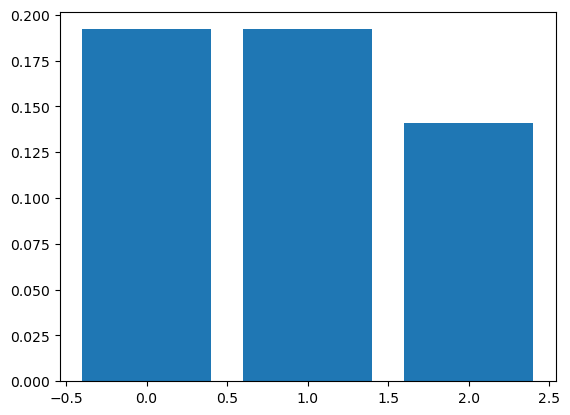

In [353]:
plt.bar(range(len(all_logical_entropies)), all_logical_entropies)

In [ ]:
noise = BiasedPauliNoise(0.01, 0.0001, 9)
print(noise.entropy(), noise.entropy_1q())

<BarContainer object of 3 artists>

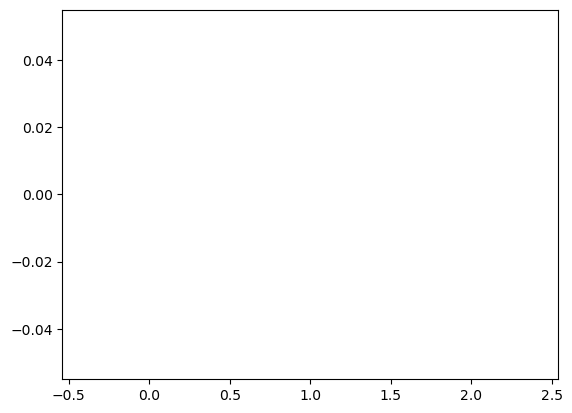

In [354]:
plt.bar(range(len(all_conditional_entropies)), all_conditional_entropies)

In [355]:
surface_code.tableau

stim.Tableau.from_conjugated_generators(
    xs=[
        stim.PauliString("+______XXX"),
        stim.PauliString("+__ZZZ____"),
        stim.PauliString("+__Z______"),
        stim.PauliString("+__Z_Z____"),
        stim.PauliString("+__Z__Z___"),
        stim.PauliString("+XX____XXX"),
        stim.PauliString("+________X"),
        stim.PauliString("+X_____XXX"),
        stim.PauliString("+_______XX"),
    ],
    zs=[
        stim.PauliString("+Z__Z__Z__"),
        stim.PauliString("+X__X_____"),
        stim.PauliString("+_XX_XX___"),
        stim.PauliString("+___XX_XX_"),
        stim.PauliString("+_____X__X"),
        stim.PauliString("+_ZZ______"),
        stim.PauliString("+____ZZ_ZZ"),
        stim.PauliString("+ZZ_ZZ____"),
        stim.PauliString("+______ZZ_"),
    ],
)

In [356]:
surface_code.destabilizers[0]

stim.PauliString("+__ZZZ____")

In [357]:
surface_code.tableau(surface_code.destabilizers[0])

stim.PauliString("+_XXX__XXX")

In [358]:
for destab in surface_code.destabilizers:
    print(destab)
    print(surface_code.syndrome(destab))

+__ZZZ____
[1. 0. 0. 0. 0. 0. 0. 0.]
+__Z______
[0. 1. 0. 0. 0. 0. 0. 0.]
+__Z_Z____
[0. 0. 1. 0. 0. 0. 0. 0.]
+__Z__Z___
[0. 0. 0. 1. 0. 0. 0. 0.]
+XX____XXX
[0. 0. 0. 0. 1. 0. 0. 0.]
+________X
[0. 0. 0. 0. 0. 1. 0. 0.]
+X_____XXX
[0. 0. 0. 0. 0. 0. 1. 0.]
+_______XX
[0. 0. 0. 0. 0. 0. 0. 1.]


<BarContainer object of 3 artists>

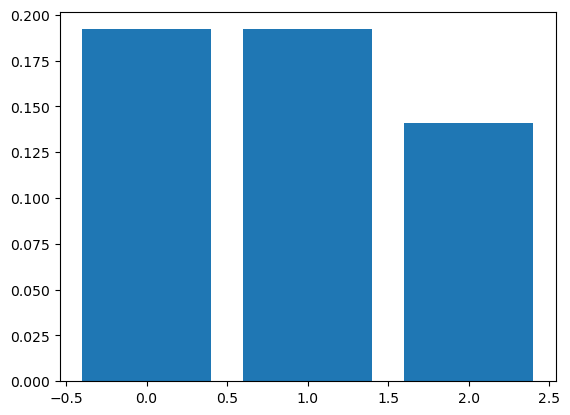

In [359]:
plt.bar(range(len(all_mutual_infos)), all_mutual_infos)

In [360]:
logical_vec = np.array(list(calculate_logical_marginal_distribution(joint_dist).values()))
entropy(logical_vec, base=2)

0.140856356777118

In [361]:
calculate_logical_entropy(joint_dist)

0.140856356777118

In [362]:
calculate_syndrome_marginal_distribution(joint_dist)
syndrome_vec = np.array(list(calculate_syndrome_marginal_distribution(joint_dist).values()))
entropy(syndrome_vec, base=2)

0.7427259522847506

In [363]:
joint_vec = np.array(list(joint_dist.values()))
entropy(joint_vec, base=2)

0.7427259522847506

In [364]:
calculate_logical_entropy(joint_dist)

0.140856356777118

In [365]:
calculate_conditional_entropy(joint_dist)

0.0

In [366]:
calculate_mutual_information(joint_dist)

0.140856356777118